In [1]:
import pickle
import numpy as np
import math
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler    
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

In [2]:
filename_1 = "OpenBCI-RAW-2020-09-14_RileyYesNoTwoMin.pkl"
filename_2 = "OpenBCI-RAW-2020-09-14_RileyYesTwoMin.pkl"
filename_3 = "OpenBCI-RAW-2020-09-14_RileyYESTwoMinSecond.pkl"
filename_4 = "OpenBCI-RAW-2020-09-04_11-46-16-YES (3).pkl"
filename_5 = "OpenBCI-RAW-2020-09-14_RileyTwoMinNO.pkl"
filename_6 = "OpenBCI-RAW-2020-09-14_RileyNOTwoMinSecond.pkl"

In [3]:
infile_1 = open(filename_1, 'rb')
infile_2 = open(filename_2, 'rb')
infile_3 = open(filename_3, 'rb')
infile_4 = open(filename_4, 'rb')
infile_5 = open(filename_5, 'rb')
infile_6 = open(filename_6, 'rb')

mixed_data_1 = pickle.load(infile_1)
data_yes_1 = pickle.load(infile_2)
data_yes_2 = pickle.load(infile_3)
data_yes_3 = pickle.load(infile_4)
data_no_1 = pickle.load(infile_5)
data_no_2 = pickle.load(infile_6)

infile_1.close()
infile_2.close()
infile_3.close()
infile_4.close()
infile_5.close()
infile_6.close()

In [4]:
print("mixed_data_1 size:", len(mixed_data_1), len(mixed_data_1[0]), len(mixed_data_1[0][0]))
print("data_yes_1 size:", len(data_yes_1), len(data_yes_1[0]), len(data_yes_1[0][0]))
print("data_yes_2 size:", len(data_yes_2), len(data_yes_2[0]), len(data_yes_2[0][0]))
print("data_yes_3 size:", len(data_yes_3), len(data_yes_3[0]), len(data_yes_3[0][0]))
print("data_no_1 size:", len(data_no_1), len(data_no_1[0]), len(data_no_1[0][0]))
print("data_no_2 size:", len(data_no_2), len(data_no_2[0]), len(data_no_2[0][0]))

mixed_data_1 size: 69 7 500
data_yes_1 size: 69 7 500
data_yes_2 size: 69 7 500
data_yes_3 size: 62 7 500
data_no_1 size: 71 7 500
data_no_2 size: 69 7 500


In [5]:
# visualize mixed data
channels = len(data_no_1[0])
length = len(data_no_1)
time = np.array([i/250 for i in range(0, 500, 1)])

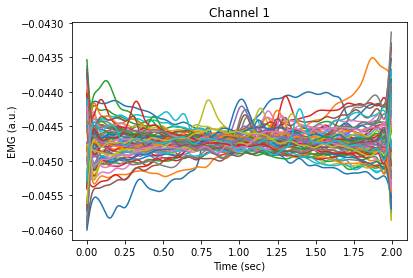

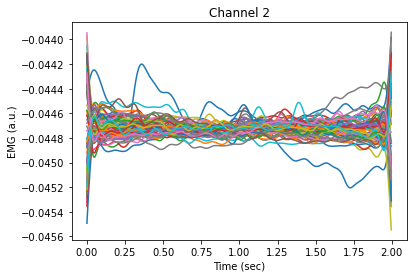

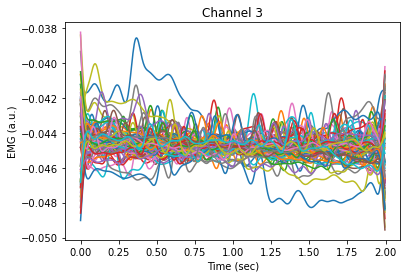

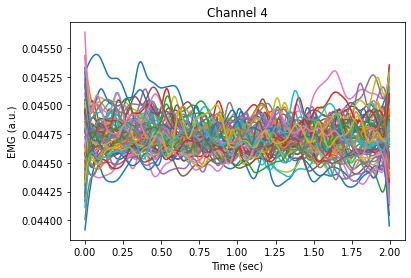

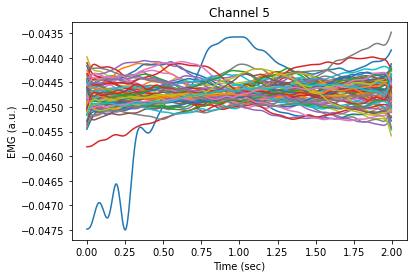

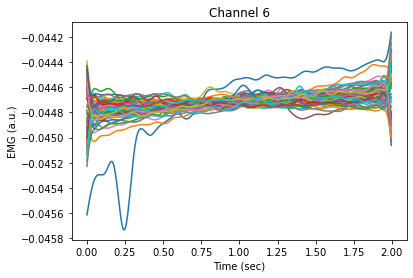

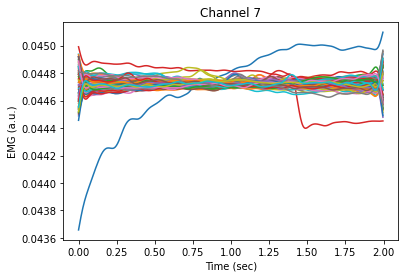

In [6]:
for sample in range(1, length):
    for channel in range(channels):
        plt.figure(channel)
        plt.xlabel('Time (sec)')
        plt.ylabel('EMG (a.u.)')
        plt.title("Channel {}".format(channel+1))
        plt.plot(time, data_no_1[sample][channel])

In [8]:
X = np.concatenate((mixed_data_1[1:], data_yes_1[1:], data_yes_2[1:], data_yes_3[1:], data_no_1[1:], data_no_2[1:]))
print(len(X))

403


In [9]:
labels_1 = np.genfromtxt("OpenBCI-RAW-2020-09-14_RileyYesNoTwoMin_labels.csv",delimiter=',')
labels_1 = np.reshape(labels_1[1:], (68,1))
labels_2 = [[1] for i in range(1, len(data_yes_1))]
labels_2 = np.reshape(labels_2, (len(labels_2),1))
labels_3 = [[1] for i in range(1, len(data_yes_2))]
labels_3 = np.reshape(labels_3, (len(labels_3),1))
labels_4 = [[1] for i in range(1, len(data_yes_3))]
labels_4 = np.reshape(labels_4, (len(labels_4),1))
labels_5 = [[0] for i in range(1, len(data_no_1))]
labels_5 = np.reshape(labels_5, (len(labels_5),1))
labels_6 = [[0] for i in range(1, len(data_no_2))]
labels_6 = np.reshape(labels_6, (len(labels_6),1))
y = np.concatenate((labels_1, labels_2, labels_3, labels_4, labels_5, labels_6))
print(len(y))

403


In [10]:
X_train_UN, X_test_UN, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=69)
print(len(X_train_UN), len(X_test_UN))

270 133


In [11]:
X_train = np.zeros((270,7,500))
X_test = np.zeros((133,7,500))
scaler = StandardScaler()
for i in range(len(X_train_UN)):
    X_train[i] = scaler.fit_transform(X_train_UN[i])
for j in range(len(X_test_UN)):
    X_test[j] = scaler.fit_transform(X_test_UN[j])

In [40]:
EPOCHS = 10
BATCH_SIZE = 1
LEARNING_RATE = 0.001

In [41]:
## train data
class trainData(Dataset):
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)


train_data = trainData(torch.FloatTensor(X_train), 
                       torch.FloatTensor(y_train))
## test data    
class testData(Dataset):
    
    def __init__(self, X_data):
        self.X_data = X_data
        
    def __getitem__(self, index):
        return self.X_data[index]
        
    def __len__ (self):
        return len(self.X_data)
    

test_data = testData(torch.FloatTensor(X_test))

In [42]:
train_loader = DataLoader(dataset=train_data, shuffle=True)
test_loader = DataLoader(dataset=test_data, batch_size=1)

In [43]:
class binaryClassification(nn.Module):
    def __init__(self):
        super(binaryClassification, self).__init__()

        self.relu = nn.ReLU()
        self.conv1 = nn.Conv1d(7, 200, 12)
        self.pool1 = nn.MaxPool1d(2, 2)
        self.conv2 = nn.Conv1d(200, 200, 6)
        self.pool2 = nn.MaxPool1d(2, 2)
        self.dropout = nn.Dropout(p=0.1)
        self.fc1 = nn.Linear(23800, 1)
        
    def forward(self, inputs):
        x = self.relu(self.conv1(inputs))
        x = self.pool1(x)
        x = self.relu(self.conv2(x))
        x = self.pool2(x)
        x = x.view(x.shape[0], -1)
        x = self.dropout(x)
        x = self.fc1(x)
        
        return x

In [44]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [45]:
model = binaryClassification()
model.to(device)
print(model)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

binaryClassification(
  (relu): ReLU()
  (conv1): Conv1d(7, 200, kernel_size=(12,), stride=(1,))
  (pool1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(200, 200, kernel_size=(6,), stride=(1,))
  (pool2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.1, inplace=False)
  (fc1): Linear(in_features=23800, out_features=1, bias=True)
)


In [46]:
def binary_acc(y_pred, y_test):
    y_pred_tag = torch.round(torch.sigmoid(y_pred))

    correct_results_sum = (y_pred_tag == y_test).sum().float()
    acc = correct_results_sum/y_test.shape[0]
    acc = torch.round(acc * 100)
    
    return acc

In [47]:
model.train()
for e in range(1, EPOCHS+1):
    epoch_loss = 0
    epoch_acc = 0
    for X_batch, y_batch in train_loader:

        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        
        y_pred = model(X_batch)
        loss = criterion(y_pred, y_batch)
        acc = binary_acc(y_pred, y_batch)
        
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()

    print(f'Epoch {e+0:03}: | Loss: {epoch_loss/len(train_loader):.5f} | Acc: {epoch_acc/len(train_loader):.3f}')

Epoch 001: | Loss: 0.63637 | Acc: 60.000
Epoch 002: | Loss: 0.57270 | Acc: 62.222
Epoch 003: | Loss: 0.57741 | Acc: 62.222
Epoch 004: | Loss: 0.84088 | Acc: 60.370
Epoch 005: | Loss: 0.56980 | Acc: 61.481
Epoch 006: | Loss: 0.57516 | Acc: 62.963
Epoch 007: | Loss: 0.57835 | Acc: 62.963
Epoch 008: | Loss: 0.56720 | Acc: 62.593
Epoch 009: | Loss: 0.56640 | Acc: 62.963
Epoch 010: | Loss: 0.56684 | Acc: 62.963


In [48]:
y_pred_list = []
model.eval()
with torch.no_grad():
    for X_batch in test_loader:
        X_batch = X_batch.to(device)
        y_test_pred = model(X_batch)
        y_test_pred = torch.sigmoid(y_test_pred)
        y_pred_tag = torch.round(y_test_pred)
        y_pred_list.append(y_pred_tag.cpu().numpy())

y_pred_list = [a.squeeze().tolist() for a in y_pred_list]

In [49]:
confusion_matrix(y_test, y_pred_list)

array([[51,  0],
       [57, 25]])

In [50]:
print(classification_report(y_test, y_pred_list))

              precision    recall  f1-score   support

         0.0       0.47      1.00      0.64        51
         1.0       1.00      0.30      0.47        82

    accuracy                           0.57       133
   macro avg       0.74      0.65      0.55       133
weighted avg       0.80      0.57      0.53       133

